In [ ]:
# %pip install mediapipe
import cv2 as cv
from cvzone.HandTrackingModule import HandDetector
import numpy as np
import math
import time
import os
import random

In [22]:
# Initialize Webcam
cap = cv.VideoCapture(0)
cap.set(3, 640)  # Set width
cap.set(4, 480)  # Set height

# Initialize Hand Detector
detector = HandDetector(maxHands=1)

# Image Processing Variables
offset = 20
imgSize = 300
counter = 0

# Define Hand Signs and Folder Structure
sign_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
current_sign_index = 0  # Track which sign we are collecting
folder_base = "D:\SEMESTER 5\CO542-2024  Neural Networks and Fuzzy Systems\Project\Sign-Language-Recognition-master\model\hand_sign_letters\hand_signs2"

# Create folders for each sign
for label in sign_labels:
    os.makedirs(os.path.join(folder_base, label), exist_ok=True)

print(f"Collecting images for sign: {sign_labels[current_sign_index]}")
while True:
    success, img = cap.read()
    if not success:
        print("Error: Could not access the webcam!")
        break


    # img = cv.flip(img, 1)  # Flip image horizontally for easier viewing
    hands, img = detector.findHands(img)

    if hands:
        hand = hands[0]
        x, y, w, h = hand["bbox"]

        imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255

        # Clamp the crop coordinates
        h_img, w_img, c_img = img.shape
        y1, y2 = max(0, y - offset), min(h_img, y + h + offset)
        x1, x2 = max(0, x - offset), min(w_img, x + w + offset)

        imgCrop = img[y1:y2, x1:x2]

        if imgCrop.size == 0:
            print("Error: Cropped image is empty!")
            continue

        aspectRatio = h / w

        if aspectRatio > 1:
            # Height > Width (Tall Image)
            k = imgSize / h
            wCal = math.ceil(k * w)
            imgResize = cv.resize(imgCrop, (wCal, imgSize))
            wGap = math.ceil((imgSize - wCal) / 2)
            imgWhite[:, wGap:wGap+imgResize.shape[1]] = imgResize
        else:
            # Width > Height (Wide Image)
            k = imgSize / w
            hCal = math.ceil(k * h)
            imgResize = cv.resize(imgCrop, (imgSize, hCal))
            hGap = math.ceil((imgSize - hCal) / 2)
            imgWhite[hGap:hGap+imgResize.shape[0], :] = imgResize

        # Data Augmentation
        imgFlipped = cv.flip(imgWhite, 1)  # Flip image horizontally
        brightness = random.randint(-30, 30)  # Random brightness adjustment
        imgBright = cv.convertScaleAbs(imgWhite, alpha=1, beta=brightness)

        # Display Images
        cv.imshow("ImageCrop", imgCrop)
        cv.imshow("ImageWhite", imgWhite)
        cv.imshow("Augmented Flip", imgFlipped)
        cv.imshow("Augmented Bright", imgBright)

    # Display Current Sign Label
    cv.putText(img, f"Sign: {sign_labels[current_sign_index]}", (20, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    cv.putText(img, f"Images: {counter}", (20, 90), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv.LINE_AA)
    
    cv.imshow("Image", img)

    key = cv.waitKey(1)

    if key == ord('s'):  # Save Image
        counter += 1
        timestamp = time.strftime("%Y%m%d-%H%M%S")  # Format: YYYYMMDD-HHMMSS
        save_folder = os.path.join(folder_base, sign_labels[current_sign_index])
        
        filename1 = os.path.join(save_folder, f"Image_{timestamp}.jpg")
        filename2 = os.path.join(save_folder, f"Image_{timestamp}_flip.jpg")
        filename3 = os.path.join(save_folder, f"Image_{timestamp}_bright.jpg")

        cv.imwrite(filename1, imgWhite)
        cv.imwrite(filename2, imgFlipped)
        cv.imwrite(filename3, imgBright)

        print(f"Images saved: {filename1}, {filename2}, {filename3}")

    if key == ord('n'):  # Switch to Next Sign
        current_sign_index = (current_sign_index + 1) % len(sign_labels)
        counter = 0
        print(f"Switched to sign: {sign_labels[current_sign_index]}")

    if key == ord('q'):  # Quit
        break

cap.release()
cv.destroyAllWindows()

In [3]:
import tensorflow as tf

# Define dataset path
dataset_path = "D:\Study\Engineering\SignLanguageProject\model\hand_signs2"

# Preprocess images
img_height, img_width = 300, 300
batch_size = 32

# Automatically label images based on folder names
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Print class labels
print("Labels:", train_data.class_indices)



Found 3687 images belonging to 26 classes.
Found 918 images belonging to 26 classes.
Labels: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


In [4]:
import tensorflow as tf

# Define CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Prevent overfitting
    tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [5]:
# Check if the dataset is loaded correctly
if len(train_data) == 0 or len(val_data) == 0:
	raise ValueError("The dataset is empty. Please check the dataset path and ensure it contains images.")

# Train the model
model.fit(train_data, validation_data=val_data, epochs=10)

# Save the trained model
model.save("sign_language_model_hand_signs.keras")

Epoch 1/10


116/116 [==============================] - 120s 1s/step - loss: 1.2731 - accuracy: 0.7413 - val_loss: 0.1610 - val_accuracy: 0.9466
Epoch 2/10
116/116 [==============================] - 114s 983ms/step - loss: 0.1020 - accuracy: 0.9713 - val_loss: 0.0957 - val_accuracy: 0.9630
Epoch 3/10
116/116 [==============================] - 117s 1s/step - loss: 0.0669 - accuracy: 0.9794 - val_loss: 0.1024 - val_accuracy: 0.9641
Epoch 4/10
116/116 [==============================] - 120s 1s/step - loss: 0.0432 - accuracy: 0.9864 - val_loss: 0.1108 - val_accuracy: 0.9684
Epoch 5/10
116/116 [==============================] - 120s 1s/step - loss: 0.0437 - accuracy: 0.9867 - val_loss: 0.1311 - val_accuracy: 0.9749
Epoch 6/10
116/116 [==============================] - 122s 1s/step - loss: 0.0451 - accuracy: 0.9875 - val_loss: 0.1265 - val_accuracy: 0.9641
Epoch 7/10
116/116 [==============================] - 123s 1s/step - loss: 0.0275 - accuracy: 0.9892 - val_loss: 0.1325 - val_accuracy: 0

In [26]:
model.evaluate(val_data)

29/29 [==============================] - 7s 237ms/step - loss: 0.2504 - accuracy: 0.9542


[0.25044405460357666, 0.9542483687400818]

In [6]:
import numpy as np

# Get the total number of samples in the validation set
num_samples = val_data.samples  

# Initialize empty arrays
X_val = []
y_val = []

# Loop through the batches and extract data
for i in range(len(val_data)):  
    X_batch, y_batch = val_data[i]  # Get one batch
    X_val.append(X_batch)  # Append features
    y_val.append(y_batch)  # Append labels

    # Break if we have collected all samples
    if len(X_val) * val_data.batch_size >= num_samples:
        break

# Convert lists to NumPy arrays
X_val = np.concatenate(X_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

print("Validation Features Shape:", X_val.shape)  # (num_samples, img_height, img_width, channels)
print("Validation Labels Shape:", y_val.shape)  # (num_samples, num_classes)


Validation Features Shape: (918, 300, 300, 3)
Validation Labels Shape: (918, 26)


29/29 [==============================] - 7s 242ms/step
CNN Model Accuracy: 0.9738562091503268


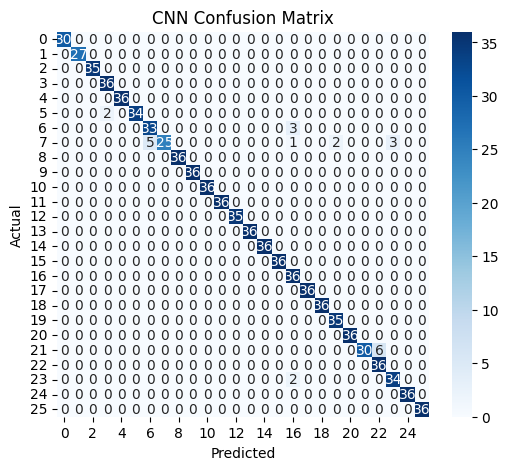

CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        35
           3       0.95      1.00      0.97        36
           4       1.00      1.00      1.00        36
           5       1.00      0.94      0.97        36
           6       0.87      0.92      0.89        36
           7       1.00      0.69      0.82        36
           8       1.00      1.00      1.00        36
           9       1.00      1.00      1.00        36
          10       1.00      1.00      1.00        36
          11       1.00      1.00      1.00        36
          12       1.00      1.00      1.00        35
          13       1.00      1.00      1.00        36
          14       1.00      1.00      1.00        36
          15       1.00      1.00      1.00        36
          16       0.86      1.00      0.92        36

In [8]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get model predictions
y_pred_probs = model.predict(X_val)  # Get probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Convert y_val from one-hot encoded format to label format
y_val_labels = np.argmax(y_val, axis=1)

# Compute metrics
accuracy = accuracy_score(y_val_labels, y_pred)
print("CNN Model Accuracy:", accuracy)

# Confusion Matrix
cm = confusion_matrix(y_val_labels, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CNN Confusion Matrix")
plt.show()

# Precision, Recall, F1-Score
print("CNN Classification Report:\n", classification_report(y_val_labels, y_pred))

# AUC-ROC (for binary or multi-class)
try:
    auc_roc = roc_auc_score(y_val, y_pred_probs, multi_class="ovr")  # Use 'ovr' for multi-class
    print("CNN Model AUC-ROC Score:", auc_roc)
except ValueError:
    print("AUC-ROC calculation failed (possible multi-class issue).")


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 149, 149, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)       0

In [27]:
import cv2 as cv
import numpy as np
import tensorflow as tf
from cvzone.HandTrackingModule import HandDetector

# Load trained model
model = tf.keras.models.load_model("D:\Study\Engineering\SignLanguageProject\model\sign_language_model_hand_signs")

# Load class labels
labels = list(train_data.class_indices.keys())

# Initialize webcam
cap = cv.VideoCapture(0)
detector = HandDetector(maxHands=1)
imgSize = 300
offset = 20

while True:
    success, img = cap.read()
    if not success:
        print("Error: Could not access webcam")
        break

    img = cv.flip(img, 1)  # Flip image horizontally for easier viewing

    hands, img = detector.findHands(img)
    if hands:
        hand = hands[0]
        x, y, w, h = hand["bbox"]

        # imgWhite = np.ones((imgSize, imgSize, 3), np.uint8) * 255

        y1, y2 = max(0, y - offset), min(img.shape[0], y + h + offset)
        x1, x2 = max(0, x - offset), min(img.shape[1], x + w + offset)
        imgCrop = img[y1:y2, x1:x2]

        if imgCrop.size != 0:
            imgResize = cv.resize(imgCrop, (imgSize, imgSize))
            imgResize = imgResize / 255.0  # Normalize pixel values
            imgResize = np.expand_dims(imgResize, axis=0)

            prediction = model.predict(imgResize)
            index = np.argmax(prediction)
            sign_label = labels[index]

            # Display prediction
            cv.putText(img, sign_label, (x, y - 10), cv.FONT_HERSHEY_SIMPLEX, 
                       1, (0, 255, 0), 2, cv.LINE_AA)

    cv.imshow("Sign Language Detection", img)

    key = cv.waitKey(1)
    if key == ord('q'):
        break

cap.release()
cv.destroyAllWindows()


1/1 [==============================] - 0s 37ms/step


In [1]:
import tensorflow as tf

# Load the SavedModel
saved_model_path = "D:/Study/Engineering/SignLanguageProject/model/lstm_sign_language_model_2"
model = tf.keras.models.load_model(saved_model_path, compile=False)

# Save in `.h5` format
model.save("D:/Study/Engineering/SignLanguageProject/model/lstm_sign_language_model.h5")


ImportError: Traceback (most recent call last):
  File "c:\Users\vithustennysan\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.